# Tensorflow RNN

A recurrent neural network written in pure tensorflow.

## Imports

In [1]:
%matplotlib inline
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from fetch_mnist import fetch_mnist

np.random.seed(1)

## Constants

In [2]:
# Data parameters
num_labels = 10 # Number of different types of labels (1-10)
num_pixels = 28*28

# Training Parameters
num_steps = 5000   # Number of training steps to run
test_size = 10000 # Test data set size
valid_size = 5000 # Validation data set size
train_size = 60000 - valid_size # Size of the training set
batch_size = 128 # Stochastic Gradient Descent batch size

# CNN Parameters
num_inputs = 1
num_timesteps = num_pixels
num_hidden_rnn = 80
num_layers_rnn = 1

# Optimization parameters
learning_rate = 0.0001 # Learning rate
decay_rate = 0.9 # learning rate decay

## Data

We use the custom MNIST data fetcher from `fetch_mnist.py`.

As a preprocessing step, the labels are converted to a one-hot encoded sparse matrix. [One hot encoding](https://en.wikipedia.org/wiki/One-hot) is just a way of replacing each integer in the label vector with a row of zeros, except at the position specified by the integer, where you put a 1.

Note that the inverse transformation of the one-hot encoding can always be performed by taking the `argmax` along `axis=1`.

Secondly, the image values are specified by an integer between 0 and 255. We convert these pixel values to a float between 0 and 1.

In contrast with the Convolutional Neural Networks, we do a pixel-by-pixel recognition of the digit image. This is a good benchmark task for a recurrent neural network. The performance of this architecture will obviously be worse than for a convnet.

In [3]:
train_data, test_data = fetch_mnist()
data = np.vstack([train_data, test_data])
np.random.shuffle(data)

train_data = data[:-test_size-valid_size]
valid_data = data[-test_size-valid_size:-test_size]
test_data  = data[-test_size:]

def get_values_labels(data):
    labels = np.int32(data[:,0])
    labels_onehot = np.zeros((len(labels), num_labels))
    labels_onehot[np.arange(len(labels)),labels] = 1
    values = np.float32(data[:,1:]).reshape(-1, num_timesteps, num_inputs)/255
    return values, labels, labels_onehot

train_values, train_labels, train_labels_onehot = get_values_labels(train_data)
valid_values, valid_labels, valid_labels_onehot = get_values_labels(valid_data)
test_values, test_labels, test_labels_onehot = get_values_labels(test_data)

print(f'train data shape:\t\t{train_values.shape}')
print(f'train labels (one-hot) shape:\t{train_labels_onehot.shape}')

train data shape:		(55000, 784, 1)
train labels (one-hot) shape:	(55000, 10)


We can visualize the different digits by writing a visualization function that reshapes the 784D train and test values into a 28x28 grid:

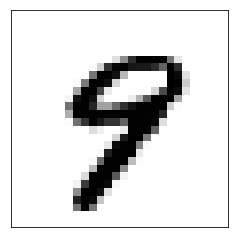

In [4]:
def show_digit(digit_array):
    plt.imshow(digit_array.reshape(28, 28), cmap='Greys')
    plt.xticks([])
    plt.yticks([])
    plt.show()
    
show_digit(train_values[31])

## Model

In [5]:
class Model(object):
    def __init__(self):
        # inputs
        self.data = tf.placeholder(tf.float32, [None, num_timesteps, num_inputs])
        self.labels = tf.placeholder(tf.int64, [None])
        
        # weights and biases
        w_init_val = np.sqrt(6.)/np.sqrt(num_labels + num_inputs)
        self.w_rnn_out = tf.get_variable("w_rnn_out", shape = [num_hidden_rnn, num_labels], dtype=tf.float32, initializer=tf.random_uniform_initializer(-w_init_val, w_init_val))
        self.b_rnn_out = tf.get_variable("b_rnn_out", shape=[num_labels], dtype=tf.float32, initializer=tf.constant_initializer(0.01))
        
        # recurrent layer
        rnn_layer = lambda : tf.contrib.rnn.BasicLSTMCell(num_hidden_rnn)
        self.rnn_cell = tf.contrib.rnn.MultiRNNCell([rnn_layer() for _ in range(num_layers_rnn)])
        rnn_out, _ = tf.nn.dynamic_rnn(self.rnn_cell, self.data, dtype=tf.float32)

        # output layer
        logits = tf.matmul(rnn_out[:,-1,:], self.w_rnn_out) + self.b_rnn_out
        
        # prediction
        self.pred = tf.nn.softmax(logits)

        # loss & accuracy
        self.loss = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits, labels=self.labels))
        self.acc = 100*tf.reduce_mean(tf.cast(tf.equal(tf.argmax(logits, 1), self.labels), tf.float32))
        
        # optimizer
        self.opt = tf.train.RMSPropOptimizer(learning_rate=learning_rate, decay=decay_rate).minimize(self.loss)
        
        # initializer
        self.init = tf.global_variables_initializer()

# Train

Create the model

In [6]:
model = Model()

Open the session

In [7]:
session = tf.Session()
session.run(model.init)

Run the session

In [8]:
%%time
history = []
for step in range(num_steps):
    idxs = np.random.randint(0, train_size, batch_size)

    if step%(train_size//batch_size) == 0 or step == num_steps -1:
        val_acc = np.zeros(valid_size//100)
        val_loss = np.zeros(valid_size//100)
        for i in range(0, valid_size, 100):
            fd={model.data:valid_values[i:i+100], model.labels:valid_labels[i:i+100]}
            val_acc[i//100], val_loss[i//100] = session.run([model.acc, model.loss], feed_dict=fd)
        history.append((step, val_loss.mean(), val_acc.mean()))
        print(f'Step {step:5.0f}\t Valid. Acc. = {val_acc.mean():5.2f}')
        
    session.run(model.opt, feed_dict={model.data:train_values[idxs], model.labels:train_labels[idxs]})

Step     0	 Valid. Acc. =  8.52
Step   429	 Valid. Acc. = 15.18
Step   858	 Valid. Acc. = 18.74
Step  1287	 Valid. Acc. = 23.54
Step  1716	 Valid. Acc. = 25.04
Step  2145	 Valid. Acc. = 23.52
Step  2574	 Valid. Acc. = 29.40
Step  3003	 Valid. Acc. = 31.94
Step  3432	 Valid. Acc. = 31.84
Step  3861	 Valid. Acc. = 37.56
Step  4290	 Valid. Acc. = 41.84
Step  4719	 Valid. Acc. = 45.96
Step  4999	 Valid. Acc. = 47.80
CPU times: user 48min 48s, sys: 3min 58s, total: 52min 47s
Wall time: 23min 42s


Training history:

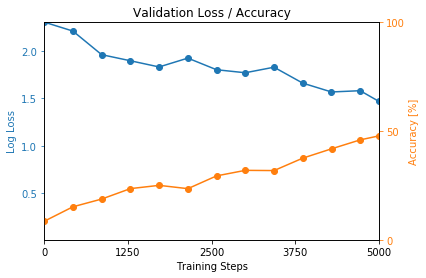

In [12]:
steps, loss, acc = zip(*history)

fig, ax_loss = plt.subplots()
ax_acc = ax_loss.twinx()

plt.sca(ax_acc)
plt.plot(steps, acc, '-o', color='C1')
plt.ylabel('Accuracy [%]', color='C1');
plt.tick_params('y', colors='C1')
plt.ylim(0,100)
plt.yticks([0,50,100])

plt.sca(ax_loss)
plt.plot(steps, loss, '-o', color='C0')
plt.ylabel('Log Loss', color='C0');
plt.tick_params('y', colors='C0')
plt.ylim(0.01, 2.3)

plt.xlim(0, max(steps))
plt.xticks([0,num_steps//4, num_steps//2, 3*num_steps//4, num_steps])
plt.xlabel('Training Steps')
plt.title('Validation Loss / Accuracy')
plt.show()

# Test

Finally, the accuracy on the test set can be evaluated:

In [13]:
test_accuracy = np.zeros(test_size//100)
for i in range(0, test_size, 100):
    fd={model.data:test_values[i:i+100], model.labels:test_labels[i:i+100]}
    test_accuracy[i//100] = session.run(model.acc, feed_dict=fd)
test_accuracy = test_accuracy.mean()
print(f'Test Accuracy = {test_accuracy:5.2f}')

Test Accuracy = 47.05


Visualize an example

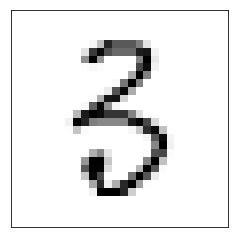

prediction=1	target=3


In [14]:
N = 315
show_digit(test_values[N])
prediction = np.argmax(session.run(model.pred, feed_dict={model.data:test_values[N:N+1]}).ravel())
print(f'prediction={prediction}\ttarget={test_labels[N]}')

In [15]:
session.close()